# GRU Model with Mean Imputation

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features+1))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features

In [10]:
X_tensor

array([[[  1.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  2.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  3.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  2.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  3.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  2.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  3.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
print(X_tensor.shape)

(12115, 336, 39)


In [12]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

print(labels.shape)

(12115,)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, labels, test_size=0.2, random_state=10
)

In [14]:
def mean_imputation(data):
    # Calculate the mean for each feature, ignoring NaNs
    means = np.nanmean(data, axis=0)
    
    # Replace NaNs with the corresponding feature means
    indices = np.where(np.isnan(data))
    data[indices] = np.take(means, indices[1])
    
    return data

In [15]:
# Replace NaNs with each feature's mean in X_train
X_train_mean_imputed = mean_imputation(X_train)

In [16]:
def create_gru_model(input_shape, learning_rate=0.001, dropout_rate=0.2, regularization_factor=0.001):
    x_input = Input(shape=input_shape)
    
    # GRU layers with dropout, batch normalization, and regularization
    gru_output = GRU(units=64, return_sequences=False, kernel_regularizer=l2(regularization_factor))(x_input)
    gru_output = BatchNormalization()(gru_output)
    gru_output = Dropout(dropout_rate)(gru_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(regularization_factor))(gru_output)
    
    # Create model
    model = Model(inputs=x_input, outputs=output)
    
    # Create an Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    
    return model

In [17]:
input_shape = (max_hours, num_features+1)
model_gru_mean = create_gru_model(input_shape)

history = model_gru_mean.fit(X_train_mean_imputed, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 5:20 663ms/step - AUC: 0.0000e+00 - loss: 0.7594

  3/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.1353 - loss: 0.7570      

  5/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.2066 - loss: 0.7549

  7/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.2551 - loss: 0.7527

  9/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3020 - loss: 0.7502

 11/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3374 - loss: 0.7477

 13/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3591 - loss: 0.7454

 15/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3697 - loss: 0.7432

 17/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3794 - loss: 0.7410

 19/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3897 - loss: 0.7386

 21/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.3979 - loss: 0.7363

 23/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4067 - loss: 0.7340

 25/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4147 - loss: 0.7315

 27/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4219 - loss: 0.7291

 29/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4280 - loss: 0.7267

 31/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4322 - loss: 0.7244

 33/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4358 - loss: 0.7220

 35/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.4394 - loss: 0.7197

 37/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4415 - loss: 0.7174

 39/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4444 - loss: 0.7151

 41/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4472 - loss: 0.7127

 43/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4496 - loss: 0.7104

 45/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4520 - loss: 0.7080

 47/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4538 - loss: 0.7057

 49/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4558 - loss: 0.7033

 51/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4582 - loss: 0.7009

 53/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4606 - loss: 0.6985

 55/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4630 - loss: 0.6960

 57/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4651 - loss: 0.6936

 59/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4671 - loss: 0.6912

 61/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4687 - loss: 0.6889

 63/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4702 - loss: 0.6865

 65/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4711 - loss: 0.6843

 67/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4721 - loss: 0.6820

 69/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4726 - loss: 0.6799

 71/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4732 - loss: 0.6777

 73/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4739 - loss: 0.6755

 75/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4744 - loss: 0.6734

 77/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4749 - loss: 0.6713

 79/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4755 - loss: 0.6692

 81/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4760 - loss: 0.6671

 83/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4763 - loss: 0.6650

 85/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4764 - loss: 0.6631

 87/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4765 - loss: 0.6611

 89/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4766 - loss: 0.6592

 91/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4768 - loss: 0.6573

 93/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4769 - loss: 0.6554

 95/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4771 - loss: 0.6535

 97/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4773 - loss: 0.6516

 99/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4777 - loss: 0.6497

101/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4781 - loss: 0.6478

103/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4784 - loss: 0.6459

105/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4786 - loss: 0.6441

107/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4788 - loss: 0.6423

109/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4790 - loss: 0.6406

111/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4791 - loss: 0.6388

113/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4793 - loss: 0.6371

115/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4795 - loss: 0.6354

117/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4798 - loss: 0.6337

119/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4801 - loss: 0.6320

121/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4802 - loss: 0.6303

123/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4804 - loss: 0.6287

125/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4806 - loss: 0.6271

127/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4808 - loss: 0.6255

129/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4811 - loss: 0.6239

131/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4812 - loss: 0.6223

133/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4814 - loss: 0.6208

135/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4815 - loss: 0.6193

137/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4816 - loss: 0.6178

139/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4818 - loss: 0.6164

141/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4820 - loss: 0.6149

143/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4821 - loss: 0.6135

145/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4823 - loss: 0.6121

147/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4824 - loss: 0.6107

149/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4825 - loss: 0.6093

151/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4825 - loss: 0.6080

153/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4826 - loss: 0.6067

155/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4827 - loss: 0.6054

157/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4828 - loss: 0.6041

159/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4830 - loss: 0.6028

161/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4831 - loss: 0.6015

163/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4832 - loss: 0.6003

165/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4833 - loss: 0.5991

167/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4834 - loss: 0.5979

169/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4835 - loss: 0.5967

171/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4836 - loss: 0.5955

173/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4836 - loss: 0.5943

175/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4837 - loss: 0.5931

177/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4838 - loss: 0.5920

179/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4839 - loss: 0.5909

181/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4840 - loss: 0.5898 

183/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4841 - loss: 0.5887

185/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4841 - loss: 0.5876

187/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4842 - loss: 0.5866

189/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4842 - loss: 0.5856

191/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4843 - loss: 0.5845

193/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4843 - loss: 0.5835

195/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4844 - loss: 0.5825

197/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4845 - loss: 0.5814

199/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4846 - loss: 0.5804

201/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4847 - loss: 0.5794

203/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4848 - loss: 0.5785

205/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4849 - loss: 0.5775

207/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4850 - loss: 0.5766

209/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4850 - loss: 0.5756

211/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4851 - loss: 0.5747

213/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4852 - loss: 0.5738

215/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4853 - loss: 0.5728

217/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4854 - loss: 0.5719

219/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4855 - loss: 0.5711

221/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4855 - loss: 0.5702

223/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4856 - loss: 0.5693

225/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4857 - loss: 0.5685

227/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4858 - loss: 0.5676

229/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4858 - loss: 0.5668

231/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4859 - loss: 0.5660

233/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4859 - loss: 0.5652

235/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4860 - loss: 0.5644

237/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4860 - loss: 0.5636

239/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4861 - loss: 0.5629

241/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4861 - loss: 0.5621

243/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4862 - loss: 0.5613

245/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4862 - loss: 0.5606

247/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4863 - loss: 0.5598

249/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4864 - loss: 0.5591

251/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4865 - loss: 0.5584

253/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4865 - loss: 0.5577

255/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4866 - loss: 0.5569

257/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4867 - loss: 0.5562

259/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4868 - loss: 0.5555

261/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4869 - loss: 0.5548

263/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4870 - loss: 0.5541

265/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4870 - loss: 0.5534

267/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4871 - loss: 0.5528

269/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4872 - loss: 0.5521

271/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4872 - loss: 0.5515

273/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4873 - loss: 0.5508

275/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4873 - loss: 0.5502

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4874 - loss: 0.5496

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4874 - loss: 0.5490

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4875 - loss: 0.5483

283/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4876 - loss: 0.5477

285/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4876 - loss: 0.5471

287/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4877 - loss: 0.5465

289/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4877 - loss: 0.5459

291/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4878 - loss: 0.5454

293/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4879 - loss: 0.5448

295/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4879 - loss: 0.5442

297/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4880 - loss: 0.5436

299/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4881 - loss: 0.5430

301/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4881 - loss: 0.5424

303/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4882 - loss: 0.5419

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4883 - loss: 0.5413

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4883 - loss: 0.5408

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4884 - loss: 0.5402

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4884 - loss: 0.5397

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4885 - loss: 0.5391

315/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4885 - loss: 0.5386

317/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4886 - loss: 0.5381

319/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4886 - loss: 0.5376

321/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4886 - loss: 0.5371

323/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4887 - loss: 0.5366

325/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4887 - loss: 0.5361

327/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4888 - loss: 0.5356

329/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4888 - loss: 0.5351

331/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4888 - loss: 0.5346

333/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4889 - loss: 0.5341

335/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4889 - loss: 0.5336

337/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4889 - loss: 0.5331

339/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4890 - loss: 0.5327

341/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4890 - loss: 0.5322

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4890 - loss: 0.5317

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4891 - loss: 0.5312

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4891 - loss: 0.5308

349/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4892 - loss: 0.5303

351/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4892 - loss: 0.5298

353/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4893 - loss: 0.5294

355/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4893 - loss: 0.5289

357/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4894 - loss: 0.5285

359/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4894 - loss: 0.5280

361/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4895 - loss: 0.5276

363/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4896 - loss: 0.5271

365/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4896 - loss: 0.5267

367/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4897 - loss: 0.5262

369/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4898 - loss: 0.5258

371/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4898 - loss: 0.5253

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4899 - loss: 0.5249

375/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4900 - loss: 0.5245

377/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4900 - loss: 0.5240

379/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4901 - loss: 0.5236

381/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4901 - loss: 0.5232

383/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4901 - loss: 0.5228

385/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4902 - loss: 0.5224

387/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4902 - loss: 0.5220

389/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4903 - loss: 0.5216

391/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4903 - loss: 0.5212

393/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4903 - loss: 0.5208

395/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4904 - loss: 0.5204

397/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4904 - loss: 0.5200

399/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4905 - loss: 0.5197

401/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4905 - loss: 0.5193

403/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4906 - loss: 0.5189

405/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4906 - loss: 0.5185

407/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4906 - loss: 0.5181

409/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4907 - loss: 0.5178

411/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4907 - loss: 0.5174

413/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4908 - loss: 0.5170

415/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4908 - loss: 0.5166

417/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4909 - loss: 0.5163

419/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4909 - loss: 0.5159

421/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4910 - loss: 0.5155

423/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.4910 - loss: 0.5151

425/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4911 - loss: 0.5148

427/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4911 - loss: 0.5144

429/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4912 - loss: 0.5141

431/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4913 - loss: 0.5137

433/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4913 - loss: 0.5133

435/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4914 - loss: 0.5130

437/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4914 - loss: 0.5126

439/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4915 - loss: 0.5123

441/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4916 - loss: 0.5119

443/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4916 - loss: 0.5116

445/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4917 - loss: 0.5112

447/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4917 - loss: 0.5109

449/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4918 - loss: 0.5106

451/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4918 - loss: 0.5102

453/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.4919 - loss: 0.5099

455/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4920 - loss: 0.5095

457/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4920 - loss: 0.5092

459/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4921 - loss: 0.5089

461/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4921 - loss: 0.5086

463/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4922 - loss: 0.5082

465/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4923 - loss: 0.5079

467/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4923 - loss: 0.5076

469/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4924 - loss: 0.5073

471/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4924 - loss: 0.5070

473/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4925 - loss: 0.5067

475/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4925 - loss: 0.5063

477/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4926 - loss: 0.5060

479/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4926 - loss: 0.5057

481/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4926 - loss: 0.5054

483/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4927 - loss: 0.5051

485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4927 - loss: 0.5048

485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 0.4927 - loss: 0.5047 - val_AUC: 0.5021 - val_loss: 0.4149


Epoch 2/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - AUC: 0.4464 - loss: 0.3867

  3/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5129 - loss: 0.3644

  5/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5421 - loss: 0.3660

  7/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5536 - loss: 0.3569

  9/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5680 - loss: 0.3584

 11/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5833 - loss: 0.3636

 13/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5879 - loss: 0.3700

 15/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5872 - loss: 0.3745

 17/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5877 - loss: 0.3787

 19/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5882 - loss: 0.3829

 21/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5889 - loss: 0.3855

 23/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5883 - loss: 0.3879

 25/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5870 - loss: 0.3895

 27/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5848 - loss: 0.3914

 29/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5825 - loss: 0.3929

 31/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5801 - loss: 0.3943

 33/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5782 - loss: 0.3950

 35/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5765 - loss: 0.3951

 37/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5750 - loss: 0.3948

 39/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5737 - loss: 0.3945

 41/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5723 - loss: 0.3944

 43/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5711 - loss: 0.3942

 45/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5702 - loss: 0.3938

 47/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5691 - loss: 0.3936

 49/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5681 - loss: 0.3933

 51/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5672 - loss: 0.3932

 53/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5661 - loss: 0.3930

 55/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5647 - loss: 0.3929

 57/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5634 - loss: 0.3928

 59/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5622 - loss: 0.3928

 61/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5613 - loss: 0.3924

 63/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5606 - loss: 0.3920

 65/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5598 - loss: 0.3916

 67/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5589 - loss: 0.3913

 69/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5579 - loss: 0.3911

 71/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5568 - loss: 0.3909

 73/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5555 - loss: 0.3908

 75/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5542 - loss: 0.3907

 77/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5528 - loss: 0.3906

 79/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5515 - loss: 0.3905

 81/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5501 - loss: 0.3905

 83/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5488 - loss: 0.3906

 85/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5474 - loss: 0.3907

 87/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5462 - loss: 0.3907

 89/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5451 - loss: 0.3908

 91/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5440 - loss: 0.3908

 93/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5431 - loss: 0.3909

 95/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5422 - loss: 0.3910

 97/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5412 - loss: 0.3910

 99/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5403 - loss: 0.3911

101/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5395 - loss: 0.3912

103/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5387 - loss: 0.3913

105/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5380 - loss: 0.3914

107/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5373 - loss: 0.3914

109/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5367 - loss: 0.3914

111/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5362 - loss: 0.3915

113/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5359 - loss: 0.3915

115/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5355 - loss: 0.3915

117/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5352 - loss: 0.3916

119/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5350 - loss: 0.3917

121/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5347 - loss: 0.3918

123/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5345 - loss: 0.3919

125/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5343 - loss: 0.3921

127/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5340 - loss: 0.3923

129/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5338 - loss: 0.3924

131/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5335 - loss: 0.3925

133/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5331 - loss: 0.3926

135/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5329 - loss: 0.3926

137/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5326 - loss: 0.3927

139/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5324 - loss: 0.3928

141/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5322 - loss: 0.3929

143/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5320 - loss: 0.3930

145/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5318 - loss: 0.3931

147/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5316 - loss: 0.3931

149/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5314 - loss: 0.3931

151/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5311 - loss: 0.3932

153/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5309 - loss: 0.3932

155/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5308 - loss: 0.3933

157/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5306 - loss: 0.3933

159/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5304 - loss: 0.3933

161/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5302 - loss: 0.3934

162/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5301 - loss: 0.3934

164/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5300 - loss: 0.3933

166/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5298 - loss: 0.3933

168/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5296 - loss: 0.3933

170/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5294 - loss: 0.3933

172/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5292 - loss: 0.3932

174/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5291 - loss: 0.3932

176/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5289 - loss: 0.3932

178/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5288 - loss: 0.3931

180/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5286 - loss: 0.3931 

182/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5285 - loss: 0.3930

184/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5283 - loss: 0.3930

186/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5282 - loss: 0.3929

188/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5281 - loss: 0.3928

190/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5280 - loss: 0.3928

192/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5278 - loss: 0.3927

194/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5277 - loss: 0.3927

196/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5275 - loss: 0.3926

198/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5274 - loss: 0.3926

200/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5272 - loss: 0.3926

202/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5271 - loss: 0.3925

204/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5270 - loss: 0.3924

206/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5269 - loss: 0.3924

208/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5268 - loss: 0.3923

210/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5267 - loss: 0.3922

212/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5265 - loss: 0.3922

214/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5264 - loss: 0.3921

216/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5263 - loss: 0.3921

218/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5262 - loss: 0.3920

220/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5261 - loss: 0.3920

222/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5260 - loss: 0.3920

224/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5259 - loss: 0.3919

226/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5257 - loss: 0.3919

228/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5256 - loss: 0.3919

230/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5255 - loss: 0.3918

232/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5254 - loss: 0.3918

234/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5253 - loss: 0.3918

236/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5253 - loss: 0.3918

238/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5252 - loss: 0.3918

240/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5251 - loss: 0.3918

242/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5250 - loss: 0.3918

244/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5249 - loss: 0.3918

246/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5248 - loss: 0.3918

248/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5247 - loss: 0.3918

250/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5247 - loss: 0.3917

252/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5246 - loss: 0.3917

254/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5245 - loss: 0.3917

256/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5245 - loss: 0.3917

258/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5244 - loss: 0.3917

260/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5244 - loss: 0.3917

262/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5243 - loss: 0.3917

264/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5243 - loss: 0.3917

266/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5243 - loss: 0.3917

268/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5242 - loss: 0.3917

270/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5242 - loss: 0.3917

272/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5242 - loss: 0.3917

274/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5242 - loss: 0.3917

276/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5241 - loss: 0.3917

278/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5241 - loss: 0.3917

280/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5241 - loss: 0.3917

282/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5240 - loss: 0.3917

284/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5240 - loss: 0.3917

286/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5240 - loss: 0.3918

288/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5240 - loss: 0.3918

290/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5239 - loss: 0.3918

292/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5239 - loss: 0.3918

294/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5239 - loss: 0.3918

296/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5238 - loss: 0.3918

298/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5238 - loss: 0.3918

300/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5238 - loss: 0.3918

302/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5238 - loss: 0.3918

304/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5238 - loss: 0.3919

306/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5238 - loss: 0.3919

308/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5237 - loss: 0.3919

310/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5237 - loss: 0.3919

312/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5237 - loss: 0.3919

314/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5237 - loss: 0.3919

316/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5237 - loss: 0.3919

318/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5237 - loss: 0.3920

320/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5236 - loss: 0.3920

322/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5236 - loss: 0.3920

324/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5236 - loss: 0.3920

326/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5235 - loss: 0.3920

328/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5235 - loss: 0.3920

330/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5235 - loss: 0.3920

332/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5235 - loss: 0.3921

334/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5235 - loss: 0.3921

336/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3921

338/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3921

340/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3922

342/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3922

344/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3922

346/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3922

348/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3922

350/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3923

352/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3923

354/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3923

356/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5234 - loss: 0.3923

358/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5233 - loss: 0.3923

360/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5233 - loss: 0.3923

362/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5233 - loss: 0.3923

364/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5233 - loss: 0.3923

366/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5233 - loss: 0.3923

368/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5233 - loss: 0.3924

370/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5233 - loss: 0.3924

372/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5233 - loss: 0.3924

374/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5233 - loss: 0.3924

KeyboardInterrupt: 

In [58]:
# Evaluate the model on the test set
X_test_filled = np.nan_to_num(X_test)
test_loss, test_auc = model_gru_mean.evaluate(X_test_filled, y_test)
print(f'Test AUC: {test_auc}')

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.7555 - loss: 0.3470
Test AUC: 0.7524358034133911


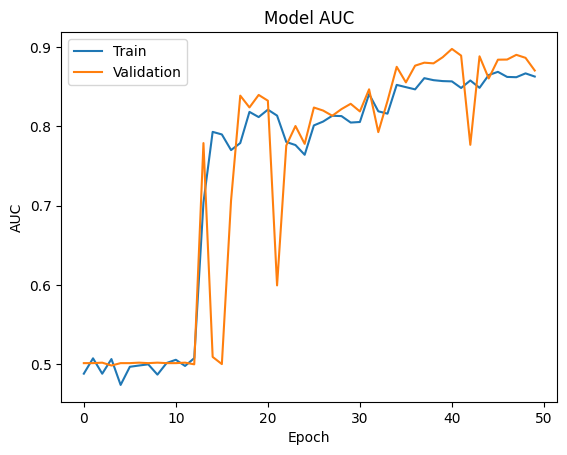

In [56]:
# Plot training & validation AUC values
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()